In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LambdaCallback
from keras.layers import Lambda
from keras.models import Model
# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

import inspect

Using TensorFlow backend.


In [3]:
print(keras.__version__) #2.2.4
print(tf.__version__) #1.15.0

2.2.4
1.15.0


# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [5]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

## Process data

In [6]:
# Path to downloaded data from Zenodo
data_dir = './data/'

In [7]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_alphaS.npz')

In [8]:
X_default = preprocess_data(default_dataset['jet'][:,:,:4])
X_unknown = preprocess_data(unknown_dataset['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [10]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)

In [11]:
X_train, X_test, Y_train, Y_test = data_split(X_fit, Y_fit, test=0.2, shuffle=True)

In [12]:
#smaller data sets
X_train_small = X_train[0:int(0.8*10**5)]
Y_train_small = Y_train[0:int(0.8*10**5)]
X_test_small = X_test[0:int(0.2*10**5)]
Y_test_small = Y_test[0:int(0.2*10**5)]

# Load Model

In [13]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)

# load model from saved file
# model trained in original alphaS notebook
dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_alphaS.h5')

# Fitting

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [14]:
# Defining reweighting functions

def reweight(d): #from NN (DCTR)
    f = dctr.model(d) # Use dctr.model.predict_on_batch(d) when using outside training
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

In [25]:
model = PFN(input_dim=4, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs = model.inputs[0]
batch_size = 1000

def my_loss_wrapper(inputs,val=0):
    x  = inputs #x.shape = (?,?,4)
    # Reshaping to correct format
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event
    
    #Creating theta_prime
    alphaS = K.ones(shape =x.shape[0:2])*val # Fitting parameter
    aLund = K.ones(shape =x.shape[0:2])*0.68 # Fixed at default
    probStoUD = K.ones(shape =x.shape[0:2])*0.217 # Fixed at default
    theta_prime = K.stack((alphaS, aLund, probStoUD), axis = 2)


    data = K.concatenate((x, theta_prime), axis =2)
    # print(data.shape) # = (batch_size, 51, 7), correct format to pass to DCTR
    w = reweight(data) # NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean-Squared Loss:
        t_loss = (y_true)*(y_true - y_pred)**2 +(w)*(1-y_true)*(y_true - y_pred)**2
        
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

[0.1    0.1025 0.105  0.1075 0.11   0.1125 0.115  0.1175 0.12   0.1225
 0.125  0.1275 0.13   0.1325 0.135  0.1375 0.14   0.1425 0.145  0.1475
 0.15   0.1525 0.155  0.1575 0.16   0.1625 0.165  0.1675 0.17   0.1725
 0.175  0.1775 0.18  ]


In [39]:
thetas = np.linspace(0.10, 0.18, 33) #iterating across possible alphaS values
vlvals = []
lvals = []


for theta in thetas:
    print("trainnig theta = :", theta)
    model.model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1)
    vlvals+=[history.history['val_loss']]
    lvals+=[history.history['loss']]
    print
    pass
print(lvals)

trainnig theta = : 0.1
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 57s 39us/step - loss: 0.1903 - acc: 0.5797 - val_loss: 0.1904 - val_acc: 0.5810
trainnig theta = : 0.10250000000000001
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 58s 40us/step - loss: 0.1920 - acc: 0.5802 - val_loss: 0.1922 - val_acc: 0.5769
trainnig theta = : 0.10500000000000001
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 58s 40us/step - loss: 0.1949 - acc: 0.5802 - val_loss: 0.1954 - val_acc: 0.5756
trainnig theta = : 0.1075
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 58s 40us/step - loss: 0.1993 - acc: 0.5813 - val_loss: 0.1998 - val_acc: 0.5826
trainnig theta = : 0.11
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/14

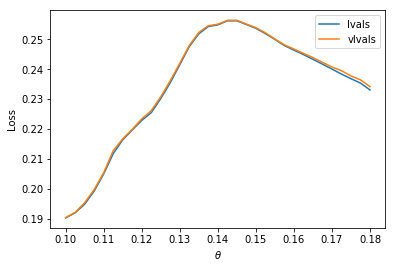

In [40]:
plt.plot(thetas,lvals, label = "lvals")
plt.plot(thetas,vlvals, label = "vlvals")
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("MSE for alphaS altFit2.png")

#incorrect maxima value? should be at alphaS = theta = 0.160

In [ ]:
#sanity check to ensure that "data" in loss wrapper is being constructed properly

'''
x  = X_test
print(x.shape)
#x = K.squeeze(x, axis = 1)
x = tf.gather(x, np.arange(2))
x = tf.gather(x, np.arange(51), axis = 1)
print(x.shape)

par1 = K.ones(shape =x.shape[0:2], dtype= tf.float64)*0.16
par2 = K.ones(shape =x.shape[0:2], dtype= tf.float64)*0.68
par3 = K.ones(shape =x.shape[0:2], dtype= tf.float64)*0.217
par = K.stack((par1, par2, par3), axis = 2)

#combining and reshaping into correct format:
#data = K.stack((x, theta0_stack), axis=-1) 
data = K.concatenate((x, par), axis =2)
print(data.shape)
w = reweight(data)
print(w.shape)
'''

In [ ]:
'''
with tf.Session() as sess:
    print(K.eval(data))
'''

# Building and Training Fitting Model

In [17]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0.18
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

In [18]:
PFN_model = PFN(input_dim=4, 
            Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_dim = 1, output_act = 'sigmoid',
            summary=False)
myinputs_fit = PFN_model.inputs[0]

identity = Lambda(lambda x: x + 0)(PFN_model.output)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False

batch_size = int(1440000/100) #larger batch_size leads to better precision (at least for Guassian case)
epochs = 10 #but requires more epochs to train

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs #x.shape = (?,?,4)
    # Reshaping to correct format
    x = tf.gather(x, np.arange(batch_size))
    x = tf.gather(x, np.arange(51), axis = 1) # Axis corressponds to (max) number of particles in each event
    
    
    
    #Getting theta0:
    if train_theta == False:
        theta0 = model_fit.layers[-1].get_weights() #when not training theta, fetch as np array 
    else:
        theta0 = model_fit.trainable_weights[-1] #when training theta, fetch as tf.Variable
        
    #Creating theta_prime
    alphaS = K.ones(shape =x.shape[0:2])*theta0 # Fitting parameter
    aLund = K.ones(shape =x.shape[0:2])*0.68 # Fixed at default
    probStoUD = K.ones(shape =x.shape[0:2])*0.217 # Fixed at default
    
    theta_prime = K.stack((alphaS, aLund, probStoUD), axis = 2)
    
    data = K.concatenate((x, theta_prime), axis =2)
    # print(data.shape) # = (batch_size, 51, 7); correct format to pass to DCTR
   
    w = reweight(data) #NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = mysign*(y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        '''
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss
    
for k in range(epochs):    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1,callbacks=callbacks)

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(X_train, Y_train, epochs=1, batch_size=batch_size,validation_data=(X_test, Y_test),verbose=1,callbacks=callbacks)    
    pass
    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_15[0][0]              
__________________________________________________________________________________________________
activation

. theta fit =  0.14359935
Training theta
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 189s 131us/step - loss: -0.2567 - acc: 0.5310 - val_loss: -0.2569 - val_acc: 0.5311
. theta fit =  0.14323358
Epoch:  9
Training g
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 164s 114us/step - loss: 0.2568 - acc: 0.5419 - val_loss: 0.2570 - val_acc: 0.5555
. theta fit =  0.14323358
Training theta
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 189s 131us/step - loss: -0.2568 - acc: 0.5570 - val_loss: -0.2571 - val_acc: 0.5555
. theta fit =  0.14406689
Epoch:  10
Training g
Train on 1440000 samples, validate on 360000 samples
Epoch 1/1
1440000/1440000 [==============================] - 165s 114us/step - loss: 0.2567 - acc: 0.5394 - val_loss: 0.2569 - val_acc: 0.5238
. theta fit =  0.14406689
Training 

KeyboardInterrupt: 

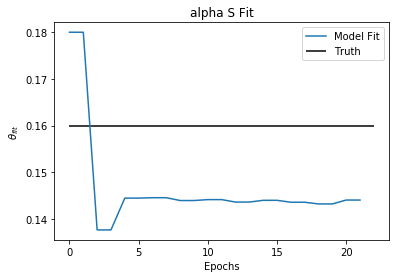

In [21]:

plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.16, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
#plt.title("N = {:.0e}, batch_size = {:.0f}, Epochs = {:.0f}".format(N, batch_size, epochs*2))
#plt.savefig(":N = {:.0e}, batch_size = {:.0f}, Epochs = {:.0f}".format(N, batch_size, epochs))
plt.title("alpha S Fit")
plt.savefig("alphaSFit.png")
plt.show()
